In [1]:
%matplotlib inline
from hurricane_gis import load_best_track
from matplotlib import style

style.use(['dark_background', 'seaborn-poster'])

- fetching data from `ERDDAP` with `erddapy`;
- static maps (`cartopy`);
- static plots (`matplotlib`).

In [2]:
from erddapy import ERDDAP


e = ERDDAP(
    server='https://data.ioos.us/gliders/erddap',
    protocol='tabledap',
)

In [3]:
[prop for prop in dir(e) if not prop.startswith('_')]

['constraints',
 'dataset_id',
 'get_download_url',
 'get_info_url',
 'get_search_url',
 'get_var_by_attr',
 'params',
 'protocol',
 'requests_kwargs',
 'response',
 'server',
 'to_iris',
 'to_pandas',
 'to_xarray',
 'variables']

In [4]:
radii, pts = load_best_track(code='al14', year='2018')

bbox = radii['geometry'].total_bounds
min_lon, max_lon = bbox[0], bbox[2]
min_lat, max_lat = bbox[1], bbox[3]

min_time = radii.index[0].strftime('%Y-%m-%dT%H:%M:%SZ')
max_time = radii.index[-1].strftime('%Y-%m-%dT%H:%M:%SZ')

In [5]:
kw = {
    'standard_name': 'sea_water_temperature',
    'min_lon': min_lon,
    'max_lon': max_lon,
    'min_lat': min_lat,
    'max_lat': max_lat,
    'min_time': min_time,
    'max_time': max_time,
    'cdm_data_type': 'trajectoryprofile'
}

In [6]:
import pandas as pd

search_url = e.get_search_url(response='csv', **kw)
search = pd.read_csv(search_url)

gliders = search['Dataset ID'].values
names = '\n'.join(gliders)
print(f'Found {len(gliders)} Glider Datasets:\n\n{names}')

Found 11 Glider Datasets:

ng228-20180801T0000
ng230-20180801T0000
ng257-20180801T0000
ng261-20180801T0000
ng279-20180801T0000
ng288-20180801T0000
ng290-20180701T0000
ng429-20180701T0000
ru33-20180801T1323
sp022-20180912T1553
sp066-20180629T1411


In [7]:
print(e.get_search_url(response='html', **kw))

https://data.ioos.us/gliders/erddap/search/advanced.html?page=1&itemsPerPage=1000&protocol=(ANY)&cdm_data_type=trajectoryprofile&institution=(ANY)&ioos_category=(ANY)&keywords=(ANY)&long_name=(ANY)&standard_name=sea_water_temperature&variableName=(ANY)&minLon=-89.233246&maxLon=-69.98774&minLat=15.705471&maxLat=38.79726&minTime=1538913600.0&maxTime=1539324000.0


In [8]:
dataset_id = 'ng288-20180801T0000'

variables = [
 'depth',
 'latitude',
 'longitude',
 'salinity',
 'temperature',
 'time',
]

In [9]:
e.dataset_id = dataset_id
e.variables = variables

In [12]:
print(e.get_download_url(response='mat'))

https://data.ioos.us/gliders/erddap/tabledap/ng288-20180801T0000.mat?depth,latitude,longitude,salinity,temperature,time


In [13]:
df = e.to_pandas(
    index_col='time (UTC)',
    parse_dates=True,
).dropna()

df.head()

,depth (m),latitude (degrees_north),longitude (degrees_east),salinity (1),temperature (Celsius)
time (UTC),,,,,
2018-08-21 03:44:15,0.992094,27.339478,-85.563141,35.689182,30.417562
2018-08-21 03:44:15,1.061540,27.339478,-85.563141,35.689510,30.416750
2018-08-21 03:44:15,1.140908,27.339478,-85.563141,35.689960,30.417750
2018-08-21 03:44:15,1.230196,27.339478,-85.563141,35.690530,30.417400
2018-08-21 03:44:15,1.299642,27.339478,-85.563141,35.691254,30.417627


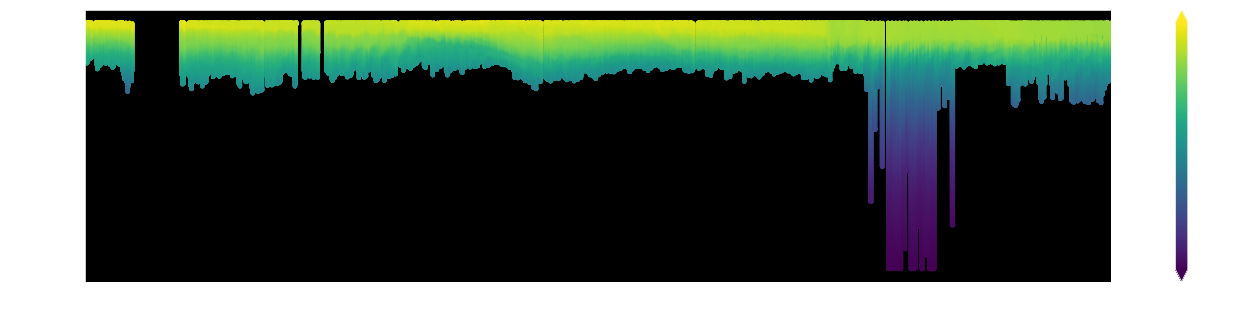

In [14]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

fig, ax = plt.subplots(figsize=(23, 5))

kw = {'marker': 'o', 'edgecolor': 'none', 's': 15}
cs = ax.scatter(df.index, df['depth (m)'],
                c=df['temperature (Celsius)'], **kw)
ax.invert_yaxis()
ax.set_xlim(df.index[0], df.index[-1])
xfmt = mdates.DateFormatter('%H:%Mh\n%d-%b')
ax.xaxis.set_major_formatter(xfmt)

cbar = fig.colorbar(cs, orientation='vertical', extend='both')
cbar.ax.set_ylabel('Temperature ($^\circ$C)')
ax.set_ylabel('Depth (m)');

In [15]:
import cartopy.crs as ccrs


def make_map(projection=ccrs.PlateCarree()):
    fig, ax = plt.subplots(
        subplot_kw={'projection': projection},
        figsize=(7, 7)
    )
    ax.stock_img()
    ax.gridlines(draw_labels=True)
    ax.coastlines('10m')
    return fig, ax

In [16]:
import shapely

dive = df.loc[df['depth (m)'] > 900]

hurr = df.loc[
    (df.index >= radii.index[0]) & (df.index <= radii.index[-1])
]

coords = zip(df['longitude (degrees_east)'],
             df['latitude (degrees_north)'])
track = shapely.geometry.LineString(coords)

intersects = radii.loc[radii['geometry'].intersects(track)]

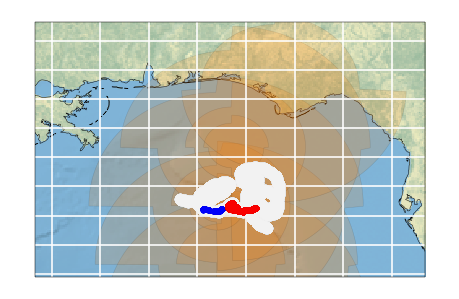

In [17]:
fig, ax = make_map()
kw = {'alpha': 0.15, 'marker': '.'}
x, y = 'longitude (degrees_east)', 'latitude (degrees_north)'

ax.plot(df[x], df[y], color='0.95', marker='o')
ax.plot(dive[x], dive[y], color='blue', **kw)
ax.plot(hurr[x], hurr[y], color='red', **kw)
ax.set_extent([df[x].min()-3, df[x].max()+3,
               df[y].min()-1, df[y].max()+3]);
ax.add_geometries(
    intersects['geometry'].tolist(), ccrs.PlateCarree(),
    facecolor='#FF7E00', alpha=0.15, edgecolor='black');